# import 

In [1]:
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import json, html, re, time
from bs4 import BeautifulSoup 
from selenium import webdriver
import numpy as np
from tqdm import tqdm
from glob import glob
from collections import Counter
from gensim.models import LdaModel
from gensim.corpora.dictionary import Dictionary
from gensim.test.utils import datapath

from datetime import timedelta, datetime
import networkx as nx
from pythainlp import word_tokenize
from pythainlp.corpus import thai_stopwords
STOPWORDS = thai_stopwords()

from error import correct

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
plt.style.use('bmh')
font_path = '/Users/Nozomi/Library/Fonts/THSarabunNew.ttf'
font_label = fm.FontProperties(fname=font_path,weight='bold',size=30)
font_title = fm.FontProperties(fname=font_path,weight='bold',size=45)

def clean(text, hashtag=None):
    if type(text) != str:
        return ''
    if hashtag:
        text = text.replace('#'+hashtag, '')
    text = html.unescape(text)
    text = correct(text)
    text = re.sub(r'http.+?(?:\\s|$)', '', text) # URL link
    text = re.sub(r'[“”„]', '"', text) # convert double quotations into "
    text = re.sub(r'[‘’′′′′`]', "'", text) # convert single quotations into '
    text = re.sub(r'[ \u00a0\xa0\u3000\u2002-\u200a\t\n#]+', ' ', text) # shrink whitespaces e.g. good  boy -> good boy
    text = re.sub(r'[\r\u200b\ufeff]+', '', text) # remove non-breaking space
    text = re.sub(r'([กทปฯอมดพบลคตวยงน])\1\1+\b', r'\1', text) # duplicated coda, 3+ characters
    text = re.sub(r'([แเาะีึุูไใโๆ])\1+', r'\1', text) # duplicated vowel, 2+ characters
    text = re.sub(r'ํา','ำ', text) # am
    text = re.sub(r'เเ+', 'แ', text)
    return text.strip()

def tokenize(text, hashtag=None):
    tokens = word_tokenize(clean(text, hashtag), keep_whitespace='False')
    tokens = [token for token in tokens if token not in STOPWORDS and re.match(r'[ก-๙][ก-๙\\.\\-]+$', token)]
    return tokens

def get_hour(row, return_string=True):
    date = datetime(row.date.year, row.date.month, row.date.day, int(row.time[:2]))
    if return_string:
        return str(date)[:-3] # '2021-04-09 22:00'
    else:
        return date # datetime.datetime(2021, 4, 9, 22, 0)

def timerange_hour(df):
    oldest = get_hour(df.iloc[len(df)-1], False)
    latest = get_hour(df.iloc[0], False)
    range_list = [str(oldest)]
    while range_list[-1] != str(latest):
        oldest = oldest + timedelta(hours=1)
        range_list.append(str(oldest))

    return pd.DataFrame([x.rsplit(':',1)[0] for x in range_list], columns=['date'])

def timerange_day(df):
    oldest = df.iloc[len(df)-1].date
    latest = df.iloc[0].date
    range_list = [str(oldest).split()[0]]
    while range_list[-1] != str(latest).split()[0]:
        oldest = oldest + timedelta(days=1)
        range_list.append(str(oldest).split()[0])
    return pd.DataFrame(range_list, columns=['date'])


userdf = pd.read_csv('follower_count.csv')

In [4]:
!ls -lh tweets/event/*tokenized.json

-rw-r--r--  1 Nozomi  staff   547M Nov 30 16:41 tweets/event/16ตุลาไปแยกปทุมวัน_tokenized.json
-rw-r--r--  1 Nozomi  staff   112M Nov 30 14:57 tweets/event/19กันยาทวงอํานาจคืนราษฏร_tokenized.json
-rw-r--r--  1 Nozomi  staff    78M Nov 30 17:14 tweets/event/25พฤศจิกาไปSCB_tokenized.json
-rw-r--r--  1 Nozomi  staff    22M Dec 23 14:36 tweets/event/WhatsHappeninginThailand_tokenized.json
-rw-r--r--  1 Nozomi  staff   152M Nov 30 17:25 tweets/event/saveวันเฉลิม_tokenized.json
-rw-r--r--  1 Nozomi  staff    78M Nov 30 17:39 tweets/event/saveอนาคตใหม่_tokenized.json
-rw-r--r--  1 Nozomi  staff   259M Nov 30 17:50 tweets/event/ม็อบ17ตุลา_tokenized.json
-rw-r--r--  1 Nozomi  staff    40M Nov 29 13:50 tweets/event/วิ่งไล่ลุง_tokenized.json
-rw-r--r--  1 Nozomi  staff   400M Nov 30 20:00 tweets/event/เยาวชนปลดแอก_tokenized.json
-rw-r--r--  1 Nozomi  staff    35M Dec 23 16:12 tweets/event/แบนแทกุกไลน์_tokenized.json
-rw-r--r--  1 Nozomi  staff   4.6M Dec 19 00:56 tweets/event/กษัตริย์มีไว้ทำไม_to

In [32]:
filename = 'tweets/event/saveอนาคตใหม่.json'
hashtag = filename.split('/')[-1].split('.')[0]#[1:] ### remove #
print(hashtag)

saveอนาคตใหม่


# tokenize & save

%%time

df = pd.read_json(filename, lines=True).drop_duplicates('id')

### define duration ###
df = df[(df.date >= '2020-01-01') & (df.date < '2022-01-01')]
df = df.reset_index(drop=True)

### clean hashtag ###
df['hashtags'] = df.hashtags.apply(lambda lst: [clean(tag) for tag in lst])

### tokenize ###
df['tokens'] = df.tweet.apply(lambda x: tokenize(x, hashtag))

### save tokenized file ###
df.to_json(filename.replace('.json','_tokenized.json'), orient='records')

# reload cleaned file

In [33]:
df = pd.read_json(filename.replace('.json','_tokenized.json'))

# time series plot

In [ ]:
plt.style.use('bmh')
### plot time series - day ###

daysdf = timerange_day(df) # list of str "2020-11-25"
fig = plt.figure(figsize=(20,15))

counts = []
for x in tqdm(daysdf['date']):
    y, m, d = map(int, x.split('-'))
    count = sum((df.date.dt.year==y) & (df.date.dt.month==m) & (df.date.dt.day==d))
    counts.append(count)
daysdf['count'] = counts

daysdf.plot(x='date', y='count', figsize=(20,15))
plt.xticks(rotation=40, size=15)
plt.yticks(size=15)
plt.title('#'+hashtag+' count of tweets', fontproperties=font_title)
plt.xlabel('date', size=25)
plt.ylabel('count of tweets', size=25)
plt.savefig(f"graphs/event/{hashtag}_count.png", facecolor="white")
plt.show()

"""

### plot time series - month ###

start_m = 1
months = [f'20-{m}' for m in range(start_m, 13)] + ['21-1','21-2']
fig = plt.figure(figsize=(20,15))

counts = []  
for y_m in months:
    y = int('20' + y_m.split('-')[0])
    m = int(y_m.split('-')[1])
    thismonth_df = df[(df.date.dt.year==y) & (df.date.dt.month==m)]
    counts.append(len(thismonth_df))

plt.plot(months, counts)
plt.xticks(months, size=15)
plt.yticks(size=15)
plt.title('#'+hashtag, fontproperties=font_title)
plt.xlabel('month', size=25)
plt.ylabel('count of tweets', size=25)
plt.show()
"""

# print num of tweets - oldest & popular & time series

In [ ]:
### hashtag (not phrase) df ###
df2 = df[df.hashtags.apply(lambda x: hashtag.lower() in x)]

### tweets have quote tweet ###
df3 = df[df.quote_url.apply(lambda x: x!= '')]

### write ###
with open(f'reports/events/#{hashtag}.md', 'w') as f:
    f.write(f'# `{hashtag}`\n\n')
    f.write(f"{str(df.date.iloc[len(df)-1]).split()[0]} {df.time.iloc[len(df)-1]} ~ {str(df.date.iloc[0]).split()[0]} {df.time.iloc[0]}")
    f.write(f"\npeak : __{str(df['date'].value_counts().index[0]).split()[0]}__ , {df['date'].value_counts()[0]} tweets/day")
    f.write(f"\n\n|||\n|:-:|:-:|\n|tweets that contain the phrase `{hashtag}` | __{len(df)}__ |\n|tweets that contain the hashtag `#{hashtag}` | __{len(df2)}__ |\n|quote tweets that contain the phrase `{hashtag}` | __{len(df3)}__ |")
    
    ### define period ###
    peakdate = df['date'].value_counts().index[0]
    df1 = df[(df.date >= peakdate - timedelta(days=3)) & (df.date <= peakdate+timedelta(days=3))]
    f.write(f"\n|||\n|tweets that contain the phrase `{hashtag}` __in period__ | __{len(df1)}__ |")
    
    ### time series graph ###
    f.write(f"\n\n![count](https://raw.githubusercontent.com/nozomiyamada/twitter_analysis/main/graphs/event/{hashtag}_count.png)")
    
    ### oldest 5 tweets ###
    f.write("\n\n## oldest 5 tweets\n\n|date|username|follower count|tweet|retweet count|\n|:-:|:-:|:-:|:-:|:-:|")
    for i, row in df.iloc[-5:].sort_values('created_at').iterrows():
        postdate = str(row['date']).split()[0] + ' ' + str(row['time'])

        try:
            follower = userdf[userdf.username == row.username].follower.values[0]
        except:
            follower = '-'

        f.write(f"\n|[{postdate}]({row.link})|[{row.username}](https://twitter.com/{row.username})|{follower}|{row.tweet}|{row.retweets_count}|")
        
    ### popular 5 tweets ###
    f.write("\n\n## most popular 10 tweets\n\n|date|username|follower count|tweet|retweet count|\n|:-:|:-:|:-:|:-:|:-:|")
    for i, row in df.sort_values('retweets_count', ascending=False).iloc[:10].iterrows():
        postdate = str(row['date']).split()[0] + ' ' + str(row['time'])

        try:
            follower = userdf[userdf.username == row.username].follower.values[0]
        except:
            follower = '-'

        f.write(f"\n|[{postdate}]({row.link})|[{row.username}](https://twitter.com/{row.username})|{follower}|{row.tweet}|{row.retweets_count}|")
        
del df2, df3

# frequent hashtag & cooccurent words

In [ ]:
##### hashtags #####
num = 15

hashtag_counter = Counter()
for lst in df.hashtags:
    hashtag_counter.update(lst)
    
hashtag2word = {x[0]:Counter() for x in hashtag_counter.most_common(num+1)[1:]}  # exclude original hashtag

# count frequent words
for i, row in df.iterrows():
    for tag in row['hashtags']:
        if tag in hashtag2word:
            hashtag2word[tag].update(row['tokens'])

with open(f'reports/events/#{hashtag}.md', 'a') as f:
    f.write("\n\n## frequent co-hashtags & co-occurrent words")
    f.write("\n\n|co-hashtag|count|frequent words|oldest|popular|\n|:-:|:-:|:-:|:-:|:-:|")
    for tag, c, in hashtag_counter.most_common(num+1)[1:]:
        tempdf = df[df.hashtags.apply(lambda x: tag in x)].sort_values(['created_at'])

        ## frequent words
        freqs = " ".join([f"{w}({c})" for w,c in hashtag2word[tag].most_common(10)])

        ## oldest
        oldest = tempdf.iloc[0].tweet
        oldest_name = tempdf.iloc[0].username
        oldest_link = tempdf.iloc[0].link
        oldest_date = str(tempdf['date'].iloc[0]).split()[0] + ' ' + str(tempdf['time'].iloc[0])

        ## popular
        tempdf = tempdf.sort_values(["retweets_count"], ascending=False)
        popular = tempdf.iloc[0].tweet
        popular_name = tempdf.iloc[0].username
        popular_link = tempdf.iloc[0].link
        popular_date = str(tempdf['date'].iloc[0]).split()[0] + ' ' + str(tempdf['time'].iloc[0])
        retweet_count = tempdf.iloc[0].retweets_count

        f.write(f"\n|#{tag}|{c}|{freqs}|[{oldest_date}]({oldest_link})<br>[@{oldest_name}](https://twitter.com/{oldest_name})<br><br>{oldest.replace('|||','')}|[{popular_date}]({popular_link})<br>[@{popular_name}](https://twitter.com/{popular_name})<br>{retweet_count} retweets<br><br>{popular.replace('|||','')}|")
    f.write(f"\n\n![hashtag](https://raw.githubusercontent.com/nozomiyamada/twitter_analysis/main/graphs/event/{hashtag}_hashtag.png)")

# hashtag timeseries plot

In [ ]:
### plot hashtag time series ###

hoursdf = timerange_hour(df1) # list of str "2020-11-25 11:00"

fig = plt.figure(figsize=(20,15))

for tag, count in tqdm(hashtag_counter.most_common(8)[1:]): # exclude original hashtag
    counts = []
    for x in hoursdf['date']:
        y = int(x[:4])
        m = int(x[5:7])
        d = int(x[8:10])
        h = x[11:13]
        thishour_df = df1[(df1.date.dt.year==y) & (df1.date.dt.month==m) & (df1.date.dt.day==d) & (df1.time.str[:2]==h)]
        count = sum(thishour_df.hashtags.apply(lambda x: tag in x))
        counts.append(count)
    hoursdf[tag] = counts

fig = hoursdf.plot(x='date', figsize=(20,15))
plt.xticks(rotation=40, size=15)
plt.yticks(size=15)
plt.title('#'+hashtag+' co-hashtags (peak±3days)', fontproperties=font_title)
plt.legend(prop=font_label)
plt.xlabel('datetime (hour)', size=25)
plt.ylabel('count of co-hashtag', size=25)
plt.savefig(f"graphs/event/{hashtag}_hashtag.png", facecolor="white")
plt.show()

# LDA

In [340]:
%%time

##### MAKE CORPUS #####
num_topic = 10
tokens = df.tokens.apply(lambda x: [token for token in x if token not in hashtag])
corpus_dictionary = Dictionary(tokens)
corpus = []
for tokens_list in tqdm(tokens):
    corpus.append(corpus_dictionary.doc2bow(tokens_list))

temp_file = datapath(hashtag + str(num_topic))
    
### SAVE OR LOAD ###

lda = LdaModel(corpus, num_topics=num_topic, id2word=corpus_dictionary, passes=10)
lda.save(temp_file)

#lda = LdaModel.load(temp_file)

100%|██████████| 21754/21754 [00:00<00:00, 57145.28it/s]


CPU times: user 1min 27s, sys: 749 ms, total: 1min 28s
Wall time: 1min 28s


In [24]:
n = len(df)
result_matrix = np.zeros((n, num_topic))
for row, dist in enumerate(lda.get_document_topics(corpus[:n])):
    for tpl in dist:
        col = tpl[0]
        result_matrix[row,col] = round(tpl[1], 4) # probability of each topic

result_df = pd.DataFrame(result_matrix, columns = list(range(1, num_topic+1)))
result_df['topic'] = result_df.apply(lambda row: np.argmax(row)+1, axis=1)

columns = ['date','time','username','tweet','hashtags','link','quote_url','urls','photos','thumbnail','mentions','reply_to','replies_count','retweets_count','likes_count']
result_df = pd.concat([df[columns], result_df], axis=1)
result_df

,date,time,username,tweet,hashtags,link,quote_url,urls,photos,thumbnail,...,2,3,4,5,6,7,8,9,10,topic
0,2021-02-28,15:11:31,lovedarkchoc2,คำปราศรัยของทนายอานนท์เมื่อวันที่ 3 สิงหาคม 25...,"[ธรรมศาสตร์จะไม่ทน, 19กันยาทวงอำนาจคืนราษฎร]",https://twitter.com/lovedarkchoc2/status/13659...,,[https://freedom.ilaw.or.th/node/854],[],,...,0.0538,0.2577,0.0000,0.1791,0.0000,0.1184,0.0000,0.0000,0.0000,1
1,2021-02-25,12:41:26,ilawfx,คำปราศรัยของทนายอานนท์เมื่อวันที่ 3 สิงหาคม 25...,"[ธรรมศาสตร์จะไม่ทน, 19กันยาทวงอำนาจคืนราษฎร]",https://twitter.com/iLawFX/status/136481273167...,,[https://freedom.ilaw.or.th/node/854],[],,...,0.0538,0.2577,0.0000,0.1791,0.0000,0.1184,0.0000,0.0000,0.0000,1
2,2021-02-18,12:20:08,batmaninthai,#ประชาชนปลดแอก #เยาวชนปลดแอก #FreeYOUTH #ให้ม...,"[ประชาชนปลดแอก, เยาวชนปลดแอก, freeyouth, ให้มั...",https://twitter.com/BatmaninThai/status/136227...,,[],[https://pbs.twimg.com/media/EufB71tVcAEEU4O.jpg],https://pbs.twimg.com/media/EufB71tVcAEEU4O.jpg,...,0.5414,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0912,0.0000,2
3,2021-02-17,14:22:34,r_artisty,สนอง ภูมิใจไทย คนที่เคยหารือให้จับม็อบธรรมศาสต...,"[อภิปรายไม่ไว้วางใจ64, อภิปรายไม่ไว้วางใจรัฐบา...",https://twitter.com/R_artisty/status/136193907...,,[],[https://pbs.twimg.com/media/EuaUFFhUYAU2SQA.jpg],https://pbs.twimg.com/media/EuaUFFhUYAU2SQA.jpg,...,0.0000,0.0000,0.0526,0.0000,0.0000,0.0491,0.1377,0.7365,0.0000,9
4,2021-02-02,20:04:40,lawcunotslave,คนเดียวกับที่ยื่นคำร้องต่อศาลรัฐธรรมนูญว่า ส.ส...,[],https://twitter.com/lawcunotslave/status/13565...,https://twitter.com/MatichonOnline/status/1356...,[],[],,...,0.0666,0.0000,0.0742,0.6307,0.0000,0.0000,0.0000,0.0000,0.0000,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21749,2020-03-22,10:05:01,bluemoon___4,@NinjaHattori_30 พ่อและพี่สาวเราก็ไม่ทนค่ะ เพร...,[],https://twitter.com/bluemoon___4/status/124156...,,[],[],,...,0.0000,0.1720,0.3631,0.0000,0.0000,0.0000,0.0000,0.0000,0.2690,4
21750,2020-03-15,09:00:27,_lachememanques,กุเซดตรงนี้กุจะเข้าแพทย์ธรรมศาสตร์ย้ำแพทย์ธรรม...,[],https://twitter.com/_lachememanques/status/123...,,[],[],,...,0.0000,0.0000,0.3978,0.0000,0.1234,0.0000,0.0000,0.2951,0.1485,4
21751,2020-03-03,23:16:02,kinraideeka,โรงพยาบาลธรรมศาสตร์ จะไม่ทนแล้วนะ คิดดูว่าขนาด...,"[covit19, โรงพยาบาล, หน้ากากอนามัย, รัฐบาลเฮงซ...",https://twitter.com/kinraideeka/status/1234875...,,[],[https://pbs.twimg.com/media/ESMobrvU8AEdAIj.jpg],https://pbs.twimg.com/media/ESMobrvU8AEdAIj.jpg,...,0.0762,0.0000,0.0687,0.0000,0.3661,0.1260,0.0000,0.0966,0.1913,6
21752,2020-02-21,18:43:33,knuaea,ธรรมศาสตร์และประชาชนจะไม่ทน #Saveอนาคตใหม่,[saveอนาคตใหม่],https://twitter.com/KNuaea/status/123082034955...,https://twitter.com/papahulahoop/status/123079...,[],[],,...,0.3271,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.4062,0.0333,9


In [25]:
with open(f'reports/events/#{hashtag}.md', 'a') as f:
    ### print result of 20 keywords ###z
    f.write("\n\n## LDA\n\n> KEYWORDS")
    
    #print('|rank|topic 1||topic 2||topic 3||topic 4||topic 5||\n|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|')
    f.write('\n\n|rank|topic 1||topic 2||topic 3||topic 4||topic 5||topic 6||topic 7||topic 8||topic 9||topic 10||')
    f.write('\n|:-:|' + ':-:|:-:|'*num_topic)
    for i in range(20):
        f.write(f'\n|{i+1}|')
        for j in range(num_topic):
            word, score = lda.show_topic(j, topn=20)[i]
            f.write(f"{word}|{score:.3f}|")
    
    
    ### PREDICTION EXAMPLE ###
    f.write("\n\n> PREDICTION EXAMPLES")
    f.write('\n\n|tweet|topic|prob of 1|2|3|4|5|6|7|8|9|10|')
    f.write('\n|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|')
    np.random.seed(10)
    for i, row in result_df[['tweet','topic',1,2,3,4,5,6,7,8,9,10]].sample(10).iterrows():
        f.write(f'\n|{row.tweet}|__{row.topic}__|{row[1]:.3f}|{row[2]:.3f}|{row[3]:.3f}|{row[4]:.3f}|{row[5]:.3f}|{row[6]:.3f}|{row[7]:.3f}|{row[8]:.3f}|{row[9]:.3f}|{row[10]:.3f}|')   
        
    #### time series plot ####
    f.write('\n\n> TIME SERIES')
    f.write(f"\n\n![topic](https://raw.githubusercontent.com/nozomiyamada/twitter_analysis/main/graphs/event/{hashtag}_topic.png)")

# plot topic time series

CPU times: user 11.5 s, sys: 392 ms, total: 11.9 s
Wall time: 15.1 s


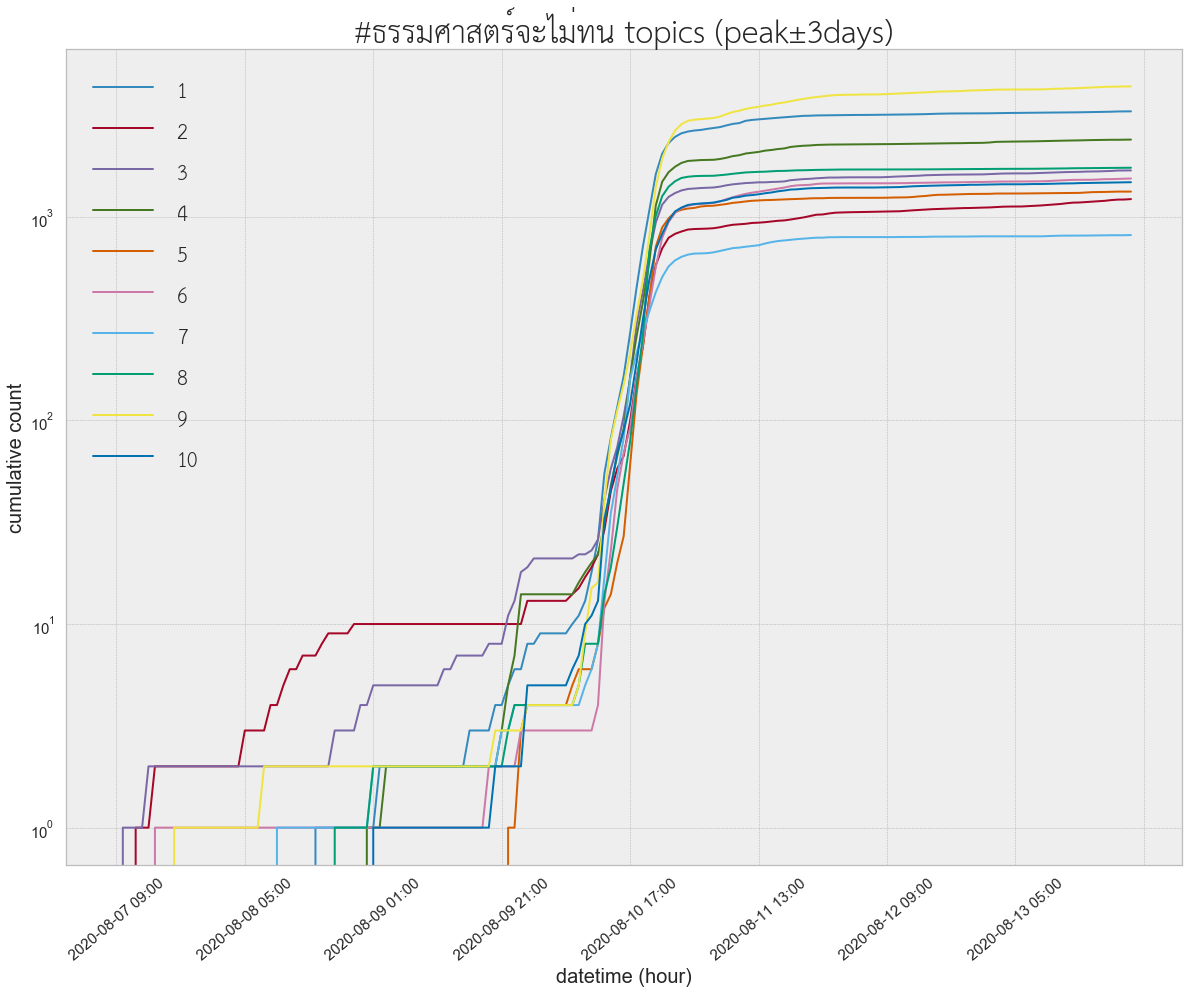

In [34]:
%%time
period_df = result_df.loc[df1.index]
period_df['datetime'] = period_df.apply(lambda row:str(row['date']).split()[0] + ' ' + str(row['time']), axis=1)
tempdf = timerange_hour(period_df)


for t in range(1, num_topic+1):
    tempdf[t] = tempdf.date.apply(lambda x: sum((period_df.datetime <= x) & (period_df.topic==t)))
    
fig = tempdf.plot(x='date', figsize=(20,15))
plt.legend(prop=font_label, loc='best')
plt.ylabel('cumulative count', size=20)
plt.xlabel('datetime (hour)', size=20)
plt.xticks(rotation=40, size=15)
plt.yticks(size=15)
plt.title('#'+hashtag+' topics (peak±3days)', fontproperties=font_title)
plt.yscale('log')
plt.savefig(f"graphs/event/{hashtag}_topic.png", facecolor="white")

# save files

In [345]:
result_df.to_csv(f'tweets/event/{hashtag}_all.csv', index=False)
period_df.to_csv(f'tweets/event/{hashtag}_period.csv', index=False)

# LDA 2 (with retweet)

In [34]:
columns = ['date', 'time', 'username', 'link', 'tweet', 'retweets_count', 'likes_count','quoted']

peakdate = df['date'].value_counts().index[0]
lda2_df = df[(df.date >= peakdate - timedelta(days=3)) & (df.date <= peakdate+timedelta(days=3))]
lda2_df['quoted'] = False
num_tweet = len(lda2_df)
quote_urls = set(lda2_df.quote_url)

### RETWEET DF
retweetdf = pd.read_csv('retweet_count.csv', parse_dates=["date"])
retweetdf = retweetdf[retweetdf.url.apply(lambda x: x in quote_urls)]
retweetdf['username'] = retweetdf.url.apply(lambda x: x.split('/')[3])
retweetdf = retweetdf.rename(columns={'url':'link', 'like_count':'likes_count'})
retweetdf['retweets_count'] = retweetdf.retweet_count + retweetdf.quote_tweet_count
retweetdf['quoted'] = True
retweetdf['tokens'] = retweetdf.tweet.apply(lambda x: tokenize(x, hashtag))
num_retweet = len(retweetdf)

### UNION
lda2_df = pd.concat([lda2_df[columns+["tokens"]], retweetdf[columns+["tokens"]]], axis=0)
lda2_df = lda2_df.reset_index(drop=True)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [35]:
%%time

##### MAKE CORPUS #####
num_topic = 10
tokens = lda2_df.tokens.apply(lambda x: [token for token in x if token not in hashtag])
corpus_dictionary = Dictionary(tokens)
corpus = []
for tokens_list in tqdm(tokens):
    corpus.append(corpus_dictionary.doc2bow(tokens_list))

temp_file = datapath(hashtag + str(num_topic)+'_retweet')
    
### SAVE OR LOAD ###

lda2 = LdaModel(corpus, num_topics=num_topic, id2word=corpus_dictionary, passes=10)
lda2.save(temp_file)

#lda2 = LdaModel.load(temp_file)

100%|██████████| 50690/50690 [00:00<00:00, 56878.06it/s]


CPU times: user 3min, sys: 1.26 s, total: 3min 2s
Wall time: 3min 1s


In [36]:
n = len(lda2_df)
result_matrix = np.zeros((n, num_topic))
for row, dist in enumerate(lda2.get_document_topics(corpus[:n])):
    for tpl in dist:
        col = tpl[0]
        result_matrix[row,col] = round(tpl[1], 4) # probability of each topic

result_df = pd.DataFrame(result_matrix, columns = list(range(1, num_topic+1)))
result_df['topic'] = result_df.apply(lambda row: np.argmax(row)+1, axis=1)
result_df = pd.concat([lda2_df[columns], result_df], axis=1)
result_df

,date,time,username,link,tweet,retweets_count,likes_count,quoted,1,2,3,4,5,6,7,8,9,10,topic
0,2020-02-24,23:53:07,natt_ymykk,https://twitter.com/Natt_ymykk/status/12319854...,ขอจำน้ำหน้ามันไว้ก่อน #Saveอนาคตใหม่,0,0,False,0.0520,0.0520,0.0520,0.0520,0.0520,0.5318,0.0520,0.0520,0.0520,0.0520,6
1,2020-02-24,23:52:25,hevenfromhell,https://twitter.com/hevenfromhell/status/12319...,เอ้ออออ ก็มาอยู่​ ถึงจะแบบเป็นนักลบก็เถอะ #kku...,2,1,False,0.0111,0.2334,0.6777,0.0111,0.0111,0.0111,0.0111,0.0111,0.0111,0.0111,3
2,2020-02-24,23:52:23,mefamefamefa,https://twitter.com/mefamefamefa/status/123198...,ขิง ข่า ตะไคร้ ใส่คนใกล้ตัวที่เลือก ศก.ใหม่ มา...,0,0,False,0.4658,0.0000,0.1935,0.0000,0.0821,0.0000,0.0000,0.0000,0.0000,0.2182,1
3,2020-02-24,23:49:50,escapatory,https://twitter.com/Escapatory/status/12319845...,ระบบคัดกรองคนแบบธรรมชาติสร้าง #เวลา #สันดาน #S...,0,0,False,0.0100,0.0100,0.4254,0.0100,0.3249,0.0100,0.1795,0.0100,0.0100,0.0100,3
4,2020-02-24,23:49:01,phitakojojo2016,https://twitter.com/PhitakoJojo2016/status/123...,@WassanaNanuam @j_ktps รอดูเมื่อไหร่ไขมันในเส้...,0,0,False,0.0125,0.1375,0.0125,0.1375,0.0125,0.0125,0.6375,0.0125,0.0125,0.0125,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50685,2020-02-21,07:04,zenjournalist,https://twitter.com/zenjournalist/status/12306...,ข่าววิเคราะห์ — กษัตริย์มุ่งมั่นที่จะทำลายพรรค...,2685,610,True,0.0125,0.1980,0.3575,0.2365,0.0125,0.0125,0.1330,0.0125,0.0125,0.0125,3
50686,2020-02-24,20:21,zenjournalist,https://twitter.com/zenjournalist/status/12319...,Kasetsart University protest today,593,448,True,0.1000,0.1000,0.1000,0.1000,0.1000,0.1000,0.1000,0.1000,0.1000,0.1000,1
50687,2020-02-21,18:32,zipp_up,https://twitter.com/zipp_up/status/12308174803...,To be continued #เราไปต่อ #Saveอนาคตใหม่,466,266,True,0.1000,0.1000,0.1000,0.1000,0.1000,0.1000,0.1000,0.1000,0.1000,0.1000,1
50688,2020-02-21,16:00,zornitsaxx,https://twitter.com/zornitsaxx/status/12307791...,-ยุบพรรคอนาคตใหม่ \n-เพิกถอนสิทธิการเลือกตั้งข...,3728,519,True,0.1308,0.0000,0.0000,0.6949,0.0000,0.0438,0.0648,0.0457,0.0000,0.0000,4


In [37]:
with open(f'reports/events/#{hashtag}.md', 'a') as f:
    ### print result of 20 keywords ###z
    f.write(f"\n\n## LDA with retweet ({num_tweet}+{num_retweet} tweets)\n\n> KEYWORDS")
    
    #print('|rank|topic 1||topic 2||topic 3||topic 4||topic 5||\n|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|')
    f.write('\n\n|rank|topic 1||topic 2||topic 3||topic 4||topic 5||topic 6||topic 7||topic 8||topic 9||topic 10||')
    f.write('\n|:-:|' + ':-:|:-:|'*num_topic)
    for i in range(20):
        f.write(f'\n|{i+1}|')
        for j in range(num_topic):
            word, score = lda2.show_topic(j, topn=20)[i]
            f.write(f"{word}|{score:.3f}|")
    
    
    ### PREDICTION EXAMPLE ###
    f.write("\n\n> PREDICTION EXAMPLES")
    f.write('\n\n|tweet|topic|prob of 1|2|3|4|5|6|7|8|9|10|')
    f.write('\n|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|')
    np.random.seed(10)
    for i, row in result_df[['tweet','topic',1,2,3,4,5,6,7,8,9,10]].sample(10).iterrows():
        f.write(f'\n|{row.tweet}|__{row.topic}__|{row[1]:.3f}|{row[2]:.3f}|{row[3]:.3f}|{row[4]:.3f}|{row[5]:.3f}|{row[6]:.3f}|{row[7]:.3f}|{row[8]:.3f}|{row[9]:.3f}|{row[10]:.3f}|')   
        
    #### time series plot ####
    f.write('\n\n> TIME SERIES')
    f.write(f"\n\n![topic](https://raw.githubusercontent.com/nozomiyamada/twitter_analysis/main/graphs/event/{hashtag}_topic2.png)")
    
    

CPU times: user 12.2 s, sys: 150 ms, total: 12.4 s
Wall time: 12 s


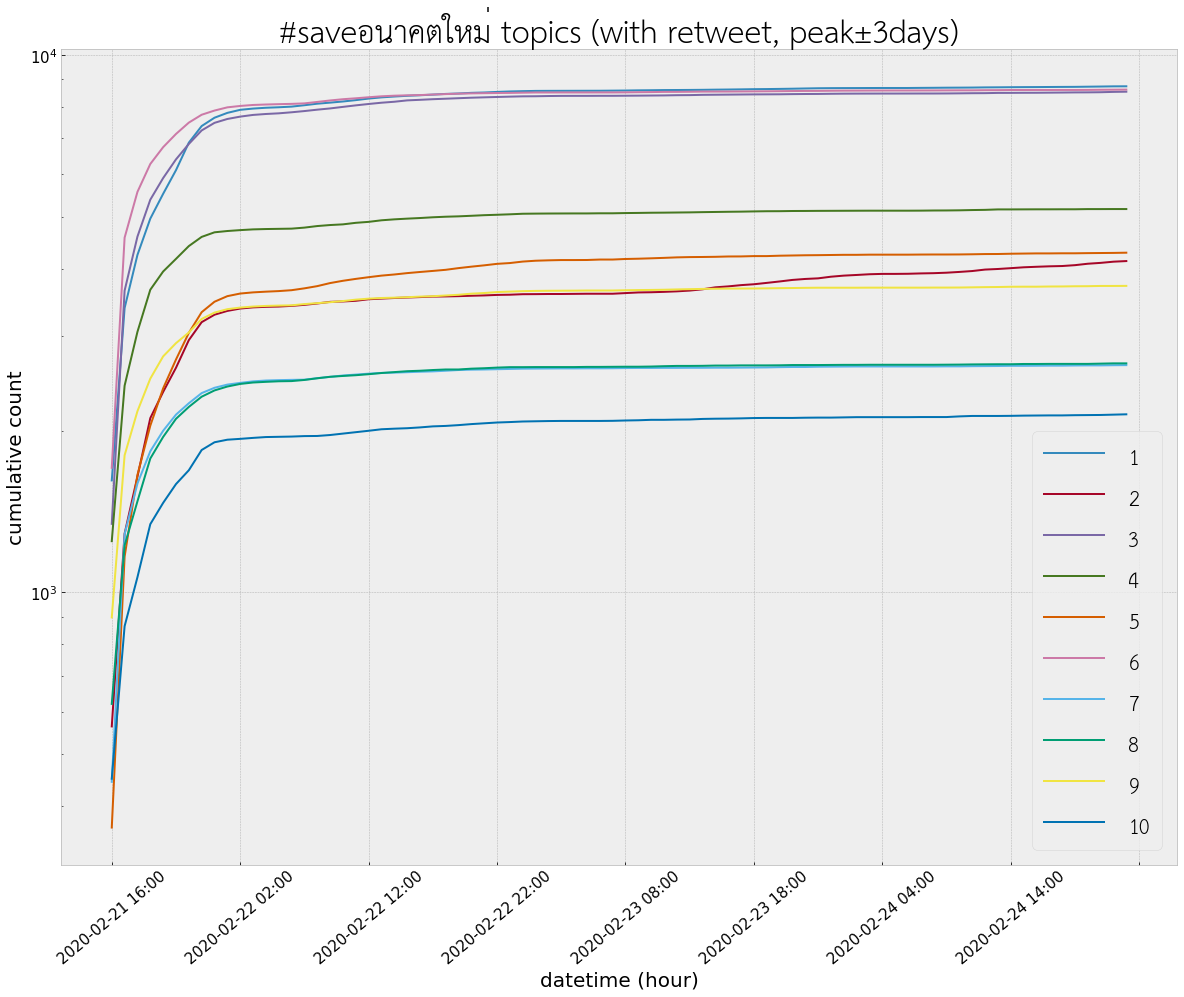

In [38]:
%%time
result_df['datetime'] = result_df.apply(lambda row:str(row['date']).split()[0] + ' ' + str(row['time']), axis=1)
tempdf = timerange_hour(result_df)

for t in range(1, num_topic+1):
    tempdf[t] = tempdf.date.apply(lambda x: sum((result_df.datetime <= x) & (result_df.topic==t)))
    
fig = tempdf.plot(x='date', figsize=(20,15))
plt.legend(prop=font_label, loc='best')
plt.ylabel('cumulative count', size=20)
plt.xlabel('datetime (hour)', size=20)
plt.xticks(rotation=40, size=15)
plt.yticks(size=15)
plt.title('#'+hashtag+' topics (with retweet, peak±3days)', fontproperties=font_title)
plt.yscale('log')
plt.savefig(f"graphs/event/{hashtag}_topic2.png", facecolor="white")

In [39]:
result_df.to_csv(f'tweets/event/{hashtag}_period_with_retweet.csv', index=False)

In [3]:
plt.style.available

['seaborn-dark',
 'seaborn-darkgrid',
 'seaborn-ticks',
 'fivethirtyeight',
 'seaborn-whitegrid',
 'classic',
 '_classic_test',
 'fast',
 'seaborn-talk',
 'seaborn-dark-palette',
 'seaborn-bright',
 'seaborn-pastel',
 'grayscale',
 'seaborn-notebook',
 'ggplot',
 'seaborn-colorblind',
 'seaborn-muted',
 'seaborn',
 'Solarize_Light2',
 'seaborn-paper',
 'bmh',
 'tableau-colorblind10',
 'seaborn-white',
 'dark_background',
 'seaborn-poster',
 'seaborn-deep']

# network

In [96]:
replydf = pd.DataFrame(columns=['replier','replyee','date','time','id'])



"""
### for reply or mention ###
for i, row in df.iterrows():
    for dic in row['reply_to']:
        replydf.loc[len(replydf)] = [row['username'], dic['screen_name']]
"""
        
### for quote_link ###

# hashtag
hashtag = 'ถ้าการเมืองดี'
tempdf = pd.concat([df, result_df.topic], axis=1) # add topic column
tempdf = tempdf[tempdf.hashtags.apply(lambda x: hashtag in x)]

all_link = sorted(tempdf.link)
count = 0
d = set()
for i, row in tqdm(tempdf.iterrows()):
    replier = row['username'] # @paolonapaul
    quote = row['quote_url']
    date_col = row['date']
    time_col = row['time']
    id_col = row['id']
    if quote in all_link:
        count += 1
        replyee = quote.split('/')[3]
        d.add(replyee)
        replydf.loc[len(replydf)] = [replier, replyee, date_col, time_col, id_col]

47143it [02:33, 307.60it/s]


In [77]:
def make_network(replydf, remove_small=False):
    print(replydf.date.iloc[0], replydf.time.iloc[0])
    
    ### make edge count dictionary ###
    edge_count = Counter()
    node_count = {}  # {node: [replied, reply]}
    
    for  i, j in zip(replydf.replier, replydf.replyee):
        edge_count[(i,j)] += 1
        
        if i not in node_count:
            node_count[i] = [0,1]
        else:
            node_count[i][1] += 1
            
        if j not in node_count:
            node_count[j] = [1,0]
        else:
            node_count[j][0] += 1
    print('----- COUNT FINISHED -----')
    
    ### NETWORK ###
    G = nx.DiGraph()  # Directed Graph

    # add nodes
    for node, tpl in node_count.items():
        if tpl[0] > tpl[1]:
            color = 'lightcoral'
        else:
            color = 'skyblue'
        G.add_node(node, color=color)

    # add edges
    G.add_weighted_edges_from([k+(v,) for k,v in edge_count.items()])

    ### remove small network ###
    if remove_small:
        node_to_remove = set()
        for node, deg in G.degree():
            if deg <= 1:
                neighbor = list(G.predecessors(node)) + list(G.successors(node))
                neighbor_deg = G.degree()(neighbor[0])
                if neighbor_deg == 1:
                    node_to_remove.add(node)
                    node_to_remove.add(neighbor[0])
            elif deg==2 and node in G[node]:
                node_to_remove.add(node)
        for node in node_to_remove:
            G.remove_node(node)
    print('----- REMOVE FINISHED -----')
    
    return nx.nx_agraph.view_pygraphviz(G, prog='fdp') , G

In [78]:
n, G = make_network(replydf.iloc[-1000:], remove_small=True)

2020-08-31 00:00:00 23:24:11
----- COUNT FINISHED -----
----- REMOVE FINISHED -----


In [20]:
soup.select_one('#react-root > div > div > div.css-1dbjc4n.r-18u37iz.r-13qz1uu.r-417010 > main > div > div > div > div > div > div:nth-child(2) > div > div > div:nth-child(1) > div > div:nth-child(3) > div > div > span')

<span class="css-901oao css-16my406 r-poiln3 r-bcqeeo r-qvutc0">Geographer, GIS Technician, Researcher</span>